#Word2Vec

In [ ]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import random

import numpy as np
import torch

def init_random_seed(value=0):
  random.seed(value)
  np.random.seed(value)
  torch.manual_seed(value)
  torch.cuda.manual_seed(value)
  torch.backends.cudnn.deterministic = True

In [ ]:
init_random_seed()

##Загрузка данных и подготовка корпуса

In [ ]:
full_dataset = list(pd.read_csv('nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print('Обучающая выборка', len(train_source))
print('Тестовая выборка', len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [ ]:
import re

TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_text_simple_regex(txt, min_token_size=4):
  txt = txt.lower()
  all_tokens = TOKEN_RE.findall(txt)
  return [token for token in all_tokens if len(token) >= min_token_size]

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
  return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [ ]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [ ]:
import collections

import numpy as np

def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
  word_counts = collections.defaultdict(int)
  doc_n = 0

  # посчитать количество документов, в которых употребляется каждое слово,
  # а также общее количество документов
  for txt in tokenized_texts:
    doc_n += 1
    unique_text_tokens = set(txt)
    for token in unique_text_tokens:
      word_counts[token] += 1

  # убрать слишком редкие и слишком частые слова
  word_counts = {word: cnt for word, cnt in word_counts.items() if cnt >= min_count and cnt / doc_n <= max_doc_freq}

  # отсортировать слова по убыванию частоты
  sorted_word_counts = sorted(word_counts.items(),
                              reverse=True,
                              key=lambda pair: pair[1])

  # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
  if pad_word is not None:
    sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

  # если у нас по-прежнему слишком много слов, оставить только max_size самых частотных
  if len(word_counts) > max_size:
    sorted_word_counts = sorted_word_counts[:max_size]

  # нумеруем слова
  word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

  # нормируем частоты слов
  word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

  return word2id, word2freq

In [ ]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print('Размер словаря', len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [ ]:
def texts_to_token_ids(tokenized_texts, word2id):
  return [[word2id[token] for token in text if token in word2id]
          for text in tokenized_texts]

In [ ]:
# отбражаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent) for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


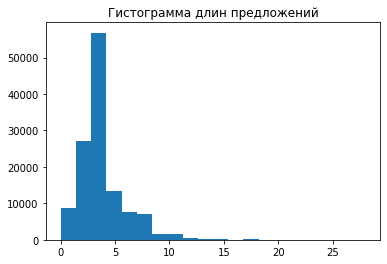

In [ ]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [ ]:
import torch
from torch.utils.data import Dataset

def ensure_length(txt, out_len, pad_value):
  if len(txt) < out_len:
    txt = list(txt) + [pad_value] * (out_len - len(txt))
  else:
    txt = txt[:out_len]
  return txt

class PaddedSequenceDataset(Dataset):
  def __init__(self, texts, targets, out_len=100, pad_value=0):
    self.texts = texts
    self.targets = targets
    self.out_len = out_len
    self.pad_value = pad_value

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    txt = self.texts[item]

    txt = ensure_length(txt, self.out_len, self.pad_value)
    txt = torch.tensor(txt, dtype=torch.long)

    target = torch.tensor(self.targets[item], dtype=torch.long)

    return txt, target

In [ ]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


##Алгоритм обучения - Skip Gram Negative Sampling

__Skip Gram__ - предсказываем соседние слова по центральному слову

__Negative Sampling__ - аппроксимация softmax

$$W, D\in\mathbb{R}^{Vocab\times EmbSise}$$
$$\sum_{CenterW_i}P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2}|CenterW_i;W, D)→\max_{W,D}$$
$$P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2}|CenterW_i;W, D)=\prod_jP(CtxW_j|CenterW_i;W,D)$$
$$P(CtxW_j|CenterW_i;W,D)=\frac{e^{w_i\cdot d_j}}{\sum^{|V|}_{j=1}e^{w_i\cdot d_j}}=softmax≃\frac{e^{w_i\cdot d_j^+}}{\sum^{k}_{j=1}e^{w_i\cdot d_j^-}}, \quad k\ll|V|$$

In [ ]:
def make_diag_mask(size, radius):
  """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
  idxs = torch.arange(size)
  abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
  mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
  return mask

In [ ]:
make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

__Negative Sampling__ работает следующим образом - мы __максимизируем сумму вероятностей двух событий:__

- "этот пример центрального слова вместе с контекстными словами взят из __тренировочной выборки__":
$$P(y=1|CenterW_i;CtxW_j)=sigmoid(w_i\cdot d_j)=\frac{1}{1+e^{-w_i\cdot d_j}}$$
- "этот пример центрального слова вместе со случайными контекстными словами __выдуман__":
$$P(y=0|CenterW_i;CtxW_{noise})=1-P(y=1|CenterW_i;CtxW_{noise})=\frac{1}{1+e^{w_i\cdot d_{noise}}}$$
$$NEG(CtxW_j, CenterW_i)=\log(\frac{1}{1+e^{-w_i\cdot d_j}})+\sum^k_{l=1}\log(\frac{1}{1+e^{w_i\cdot d_{noise_l}}})→\max_{W,D}$$

In [ ]:
class SkipGramNegativeSamplingTrainer(nn.Module):
  def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
    super().__init__()
    self.vocab_size = vocab_size
    self.negative_samples_n = negative_samples_n

    self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
    self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
    self.center_emb.weight.data[0] = 0

    self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
    self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
    self.context_emb.weight.data[0] = 0

    self.positive_sim_mask = make_diag_mask(sentence_len, radius)

  def forward(self, sentences):
    """sentences - Batch x MaxSentLength - идентификаторы токенов"""
    batch_size = sentences.shape[0]
    center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

    # оценить сходство с настоящими соседними словами
    positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
    positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
    positive_probs = torch.sigmoid(positive_sims)

    # увеличить оценку вероятности встретить эти пары слов вместе
    positive_mask = self.positive_sim_mask.to(positive_sims.device)
    positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                           positive_mask.expand_as(positive_probs))
    
    # выбрать случайные "отрицательные" слова
    negative_words = torch.randint(1, self.vocab_size,
                                   size=(batch_size, self.negative_samples_n),
                                   device=sentences.device)  # Batch x NegSamplesN
    negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
    negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x maxSentLength x NegSamplesN

    # уменьшить оценку вероятности встретить эти пары слов вместе
    negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                       negative_sims.new_zeros(negative_sims.shape))
    
    return positive_loss + negative_loss

def no_loss(pred, target):
  """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
  return pred

##Обучение

In [ ]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [ ]:
import torch

def copy_data_to_device(data, device):
  if torch.is_tensor(data):
    return data.to(device)
  elif isinstance(data, (list, tuple)):
    return [copy_data_to_device(elem, device) for elem in data]
  raise ValueError('Недопустимый тип данных {}'.format(type(data)))

In [ ]:
import copy
import datetime
import traceback

import torch
from torch.utils.data import DataLoader

def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
  """
  Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
  :param model: torch.nn.Module - обучаемая модель
  :param train_dataset: torch.utils.data.Dataset - данные для обучения
  :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
  :param criterion: функция потерь для настройки модели
  :param lr: скорость обучения
  :param epoch_n: максимальное количество эпох
  :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
  :param device: cuda/cpu - устройство, на котором выполнять вычисления
  :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
    отсутствие улучшения модели, чтобы обучение продолжалось.
  :param l2_reg_alpha: коэффициент L2-регуляризации
  :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
  :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
  :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
    (по умолчанию torch.utils.data.DataLoader)
  :return: кортеж из двух элементов:
    - среднее значение функции потерь на валидации на лучшей эпохе
    - лучшая модель
  """
  if device is None:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
  device = torch.device(device)
  model.to(device)

  if optimizer_ctor is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
  else:
    optimizer = optimizer_ctor(model.parameters(), lr=lr)

  if lr_scheduler_ctor is not None:
    lr_scheduler = lr_scheduler_ctor(optimizer)
  else:
    lr_scheduler = None

  train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                      num_workers=dataloader_workers_n)
  val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                    num_workers=dataloader_workers_n)
  
  best_val_loss = float('inf')
  best_epoch_i = 0
  best_model = copy.deepcopy(model)

  for epoch_i in range(epoch_n):
    try:
      epoch_start = datetime.datetime.now()
      print('Эпоха {}'.format(epoch_i))

      model.train()
      mean_train_loss = 0
      train_batches_n = 0
      for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
        if batch_i > max_batches_per_epoch_train:
          break

        batch_x = copy_data_to_device(batch_x, device)
        batch_y = copy_data_to_device(batch_y, device)

        pred = model(batch_x)
        loss = criterion(pred, batch_y)

        model.zero_grad()
        loss.backward()

        optimizer.step()

        mean_train_loss += float(loss)
        train_batches_n += 1

      mean_train_loss /= train_batches_n
      print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                     (datetime.datetime.now() - epoch_start).total_seconds()))
      print('Среднее значение функции потерь на обучении', mean_train_loss)

      model.eval()
      mean_val_loss = 0
      val_batches_n = 0

      with torch.no_grad():
        for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
          if batch_i > max_batches_per_epoch_val:
            break

          batch_x = copy_data_to_device(batch_x, device)
          batch_y = copy_data_to_device(batch_y, device)

          pred = model(batch_x)
          loss = criterion(pred, batch_y)

          mean_val_loss += float(loss)
          val_batches_n += 1

      mean_val_loss /= val_batches_n
      print('Среднее значение функции потерь на валидации', mean_val_loss)

      if mean_val_loss < best_val_loss:
        best_epoch_i = epoch_i
        best_val_loss = mean_val_loss
        best_model = copy.deepcopy(model)
        print('Новая лучшая модель!')
      elif epoch_i - best_epoch_i > early_stopping_patience:
        print('Модель не улучшилась за за последние {} эпох, прекращаем обучение'.format(
            early_stopping_patience))
        break

      if lr_scheduler is not None:
        lr_scheduler.step(mean_val_loss)

      print()
    except KeyboardInterrupt:
      print('Досрочно остановлено пользователем')
      break
    except Exception as ex:
      print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
      break

  return best_val_loss, best_model

In [ ]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 7.80 сек
Среднее значение функции потерь на обучении 0.8888546198919259
Среднее значение функции потерь на валидации 0.8810075783143715
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 8.29 сек
Среднее значение функции потерь на обучении 0.8782679513655324
Среднее значение функции потерь на валидации 0.877383497501609
Новая лучшая модель!



In [ ]:
torch.save(trainer.state_dict(), 'sgns.pth')

In [ ]:
trainer.load_state_dict(torch.load('sgns.pth'))

<All keys matched successfully>

##Исследуем характеристики полученных векторов

In [ ]:
import numpy as np
import scipy.sparse

class Embeddings:
  def __init__(self, embeddings, word2id):
    self.embeddings = embeddings
    self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
    self.word2id = word2id
    self.id2word = {i: w for w, i in word2id.items()}

  def most_similar(self, word, topk=10):
    return self.most_similar_by_vector(self.get_vector(word), topk=topk)

  def analogy(self, a1, b1, a2, topk=10):
    a1_v = self.get_vector(a1)
    b1_v = self.get_vector(b1)
    a2_v = self.get_vector(a2)
    query = b1_v - a1_v + a2_v
    return self.most_similar_by_vector(query, topk=topk)

  def most_similar_by_vector(self, query_vector, topk=10):
    similarities = (self.embeddings * query_vector).sum(-1)
    best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
    result = [(self.id2word[i], similarities[i]) for i in best_indices]
    result.sort(key=lambda pair: -pair[1])
    return result

  def get_vector(self, word):
    if word not in self.word2id:
      raise ValueError('Неизвестное слово "{}"'.format(word))
    return self.embeddings[self.word2id[word]]

  def get_vectors(self, *words):
    word_ids = [self.word2id[i] for i in words]
    vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
    return vectors

In [ ]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [ ]:
embeddings.most_similar('chicken')

[('chicken', 0.9999382),
 ('duck', 0.62777764),
 ('thighs', 0.60203123),
 ('breasts', 0.59222084),
 ('stock', 0.576287),
 ('broth', 0.5499114),
 ('quarts', 0.5377011),
 ('breast', 0.5312125),
 ('sodium', 0.5185101),
 ('apart', 0.5142984)]

In [ ]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('emmenthal', 1.0537125),
 ('cheeses', 1.0093094),
 ('gorgonzola', 0.999608),
 ('cheese', 0.9904547),
 ('cottage', 0.99023175),
 ('glaze', 0.9861105),
 ('sheep', 0.9747405),
 ('cacao', 0.9712295),
 ('monterey', 0.96895766),
 ('cheddar', 0.96286076)]

In [ ]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def plot_vectors(vectors, labels, how='tsne', ax=None):
  if how == 'tsne':
    projections = TSNE().fit_transform(vectors)
  elif how == 'svd':
    projections = TruncatedSVD().fit_transform(vectors)

  x = projections[:, 0]
  y = projections[:, 1]

  ax.scatter(x, y)
  for cur_x, cur_y, cur_label in zip(x, y, labels):
    ax.annotate(cur_label, (cur_x, cur_y))

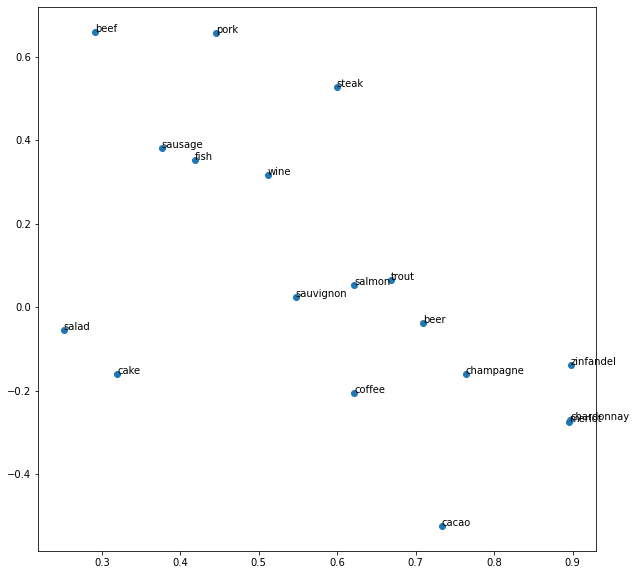

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

##Обучение Word2Vec с помощью Gensim

In [ ]:
import gensim

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [ ]:
word2vec.wv.most_similar('chicken')

[('simmering', 0.7135387659072876),
 ('duck', 0.7060984373092651),
 ('thighs', 0.6912053227424622),
 ('pheasant', 0.6816568374633789),
 ('defatted', 0.664634108543396),
 ('drumsticks', 0.6629186868667603),
 ('turkey', 0.6554433703422546),
 ('rich', 0.6447159051895142),
 ('magret', 0.6445415019989014),
 ('breasts', 0.6384820342063904)]

In [ ]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

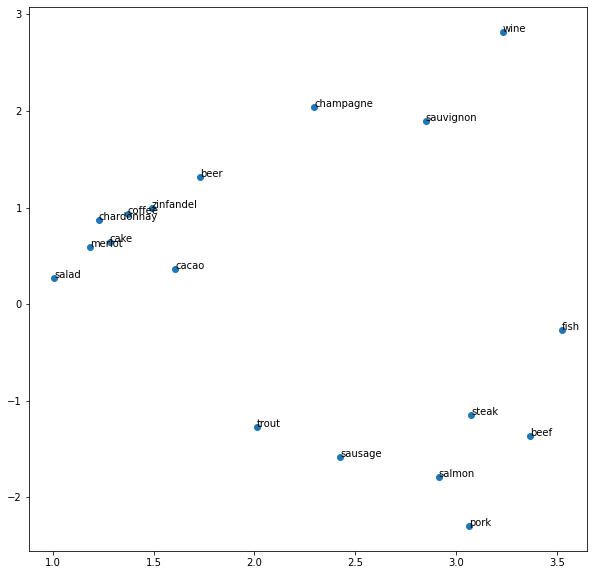

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

##Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [ ]:
import gensim.downloader as api

In [ ]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
pretrained.most_similar('cheese')

[('cheeses', 0.7789000272750854),
 ('cheddar', 0.7627596855163574),
 ('goat_cheese', 0.7297402620315552),
 ('Cheese', 0.7286962866783142),
 ('cheddar_cheese', 0.7255136966705322),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805709600448608),
 ('cheddar_cheeses', 0.6694672703742981),
 ('Camembert', 0.6623163223266602),
 ('gruyere', 0.6615148186683655)]

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077576637268066),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696184158325195),
 ('person', 0.48637545108795166)]

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

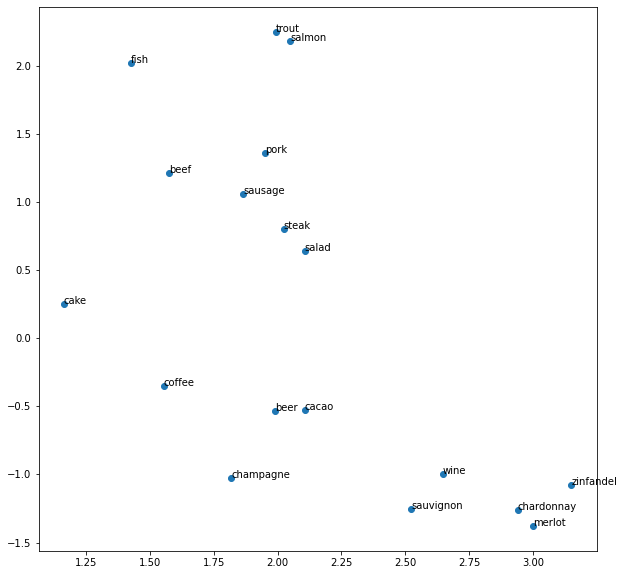

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

##Заключение

- Реализовали Skip Gram Negative Sampling на PyTorch
- Обучили на корпусе рецептов

    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных

- Обучили SGNS с помощью библиотеки Gensim
- Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)

    * Списки похожих слов отличаются!
    * Аналогии работают
